See https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme/notebook

In [1]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Normalizer, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import eli5

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

/Users/wtf/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Read training and test sets, sort train set by session start time.

In [3]:
def show_confusion_matrix(y_true,y_pred,title='Confusionmatrix'):
    table=confusion_matrix(y_true,y_pred)
    fig,ax=plt.subplots(frameon=False)
    fig.set_size_inches(4,3)
    fig.suptitle(title,fontsize=20)
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    the_table=ax.table(cellText=table,
                        colWidths=[0.5]*len([0,1]),
                        rowLabels=['True 0','True 1'],colLabels=['Predicted 0','Predicted 1'],
                        cellLoc='center',rowLoc='center',loc="center")
    the_table.set_fontsize(34)
    the_table.scale(1,4)
    plt.show()

In [4]:
# Load websites dictionary
with open(r"../../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

In [5]:
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('../../../data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('../../../data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')


# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


#### Transform data into format which can be fed into CountVectorizer

In [6]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

In [7]:
!head -5 train_sessions_text.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947


#### Fit TfidfVectorizer and transform data with it.

In [8]:
%%time
#cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
cv = TfidfVectorizer(ngram_range=(1, 3), max_features=25000, binary=True)
#cv = TfidfVectorizer(ngram_range=(1, 3), max_df=0.9)

with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
X_train.shape, X_test.shape

CPU times: user 9.92 s, sys: 296 ms, total: 10.2 s
Wall time: 8.89 s


In [9]:
X_train.shape, X_test.shape

((253561, 25000), (82797, 25000))

In [10]:
X_train.mean(), X_train.min(), X_train.max()

(0.0001294681916051883, 0.0, 1.0)

#### Save train targets into a separate vector.

In [11]:
y_train = train_df['target'].astype('int').values

#### We'll be performing time series cross-validation

We will be performing time series cross-validation, see sklearn TimeSeriesSplit and this dicussion on StackOverflow.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

In [12]:
time_split = TimeSeriesSplit(n_splits=10)

In [13]:
#X_train

In [14]:
#X_train = X_train[46102:]

In [15]:
#X_train[69153:]


In [16]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

In [17]:
#[(el[0].shape, el[1].shape) for el in time_split.split(X_train[69153:])]

#### Perform time series cross-validation with logistic regression.

In [18]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [19]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='lbfgs', max_iter=8000)

In [20]:
#logit2 = SGDClassifier(random_state=17)

In [21]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='saga')

In [22]:
logit2 = LogisticRegression(C=1, random_state=17, solver='lbfgs')

In [24]:
%%time
cv_scores = cross_val_score(logit2, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 58.1 ms, sys: 83 ms, total: 141 ms
Wall time: 4.59 s


In [25]:
cv_scores, cv_scores.mean() # 0.869185314739268

(array([0.82111676, 0.65375916, 0.88122161, 0.93802809, 0.85352904,
        0.8850267 , 0.92550447, 0.87873734, 0.93154314, 0.92338684]),
 0.869185314739268)

In [26]:
logit2.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
#eli5.show_weights(estimator=logit2, 
#                  feature_names=cv.get_feature_names(), top=30)

In [28]:
for k, v in site_dict.items():
    if v == 7832:
        print(k)

www.info-jeunes.net


#### Now we'll add some time features: indicators of morning, day, evening and night.

In [29]:
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    aalice_hour = ((hour >= 16) & (hour <= 18)).astype('int')
    
    # added in 27
    day_of_week = df['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = df['time1'].apply(lambda t: t.month).values.reshape(-1, 1)
    #year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    
    
    X = hstack([X_sparse,
                morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1),
                evening.values.reshape(-1, 1),
                night.values.reshape(-1, 1),
                #aalice_hour.values.reshape(-1, 1),
                day_of_week,
                month,
                
                #alice_hour.reshape(-1, 1)
                #year_month
                ])
    return X

In [30]:
%%time
X_train_new = add_time_features(train_df, X_train)
X_test_new = add_time_features(test_df, X_test)

CPU times: user 4.3 s, sys: 228 ms, total: 4.53 s
Wall time: 3.36 s


In [31]:
X_train_new.shape, X_test_new.shape

((253561, 25006), (82797, 25006))

In [32]:
%%time
cv_scores = cross_val_score(logit2, X_train_new, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 615 ms, sys: 79.4 ms, total: 694 ms
Wall time: 5.43 s


In [33]:
cv_scores, cv_scores.mean() # 0.9189704609766164

(array([0.78790643, 0.81038926, 0.91799004, 0.96828297, 0.92236972,
        0.9551075 , 0.94338838, 0.95016912, 0.96502327, 0.96907793]),
 0.9189704609766164)

#### Add start month feature

In [34]:
def add_start_month_feature(df, X_sparse):
    foo = pd.DataFrame(index=df.index)
    bar = df['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype('float64')
    foo['scaled_month'] = StandardScaler().fit_transform(bar.values.reshape(-1, 1))
    
    #foo['scaled_month'] = df['time1'].apply(lambda ts: (100 * ts.year + ts.month) / 1e5).astype('float64')
    
    X = hstack([X_sparse, foo])
    return X

In [35]:
%%time
X_train_new2 = add_start_month_feature(train_df, X_train_new)
X_test_new2 = add_start_month_feature(test_df, X_test_new)

CPU times: user 2.05 s, sys: 120 ms, total: 2.17 s
Wall time: 1.2 s


In [36]:
X_train_new2.shape, X_test_new2.shape

((253561, 25007), (82797, 25007))

In [37]:
X_train_new2.mean(), X_train_new2.min(), X_train_new2.max()

(0.0004413856509448721, -1.7444049642540242, 12.0)

In [38]:
%%time
cv_scores = cross_val_score(logit2, X_train_new2, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 619 ms, sys: 64.8 ms, total: 684 ms
Wall time: 5.58 s


In [39]:
cv_scores, cv_scores.std(), cv_scores.mean() # 0.9215026866467853

(array([0.78073371, 0.81060659, 0.95384592, 0.96840671, 0.92078204,
        0.95318216, 0.94403344, 0.95126547, 0.96362417, 0.96854666]),
 0.06461024923883897,
 0.9215026866467853)

#### Add session length feature

In [40]:
def add_session_length_feature(df, X_sparse):    
    foo = pd.DataFrame(index=df.index)
    foo['min_seconds'] = df[times].min(axis=1)
    foo['max_seconds'] = df[times].max(axis=1)
    foo['seconds'] = (foo['max_seconds'] - foo['min_seconds']) / np.timedelta64(1, 's')

    foo['scaled_session_duration_seconds'] = MinMaxScaler().fit_transform(foo['seconds'].values.reshape(-1, 1))
    #foo['scaled_session_duration_seconds'] = StandardScaler().fit_transform(foo['seconds'].values.reshape(-1, 1))
    
    #foo['month'] = df['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    #foo['day_of_week'] = df['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    #foo['year_month'] = df['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    #foo['day_of_week'] = df['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    #foo['scaled_day_of_week'] = MinMaxScaler().fit_transform(foo['day_of_week'].values.reshape(-1, 1))
    
    # Added in 28
    #foo['lt_48_secs'] = (foo['seconds'] < 48)
    #foo['lt_48_secs'] = foo['lt_48_secs'].astype('float64')

    #foo['gte_48_secs'] = (foo['seconds'] >= 48)
    #foo['gte_48_secs'] = foo['gte_48_secs'].astype('float64')
    
    foo = foo.drop(columns=['min_seconds', 'max_seconds', 'seconds',])
    
    X = hstack([X_sparse, foo])
    return X
    #return foo

In [41]:
%%time
X_train_new3 = add_session_length_feature(train_df, X_train_new2)
X_test_new3 = add_session_length_feature(test_df, X_test_new2)

CPU times: user 477 ms, sys: 69.2 ms, total: 546 ms
Wall time: 173 ms


In [42]:
X_train_new3.shape, X_test_new3.shape

((253561, 25008), (82797, 25008))

In [43]:
%%time
cv_scores = cross_val_score(logit2, X_train_new3, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 122 ms, sys: 55.4 ms, total: 178 ms
Wall time: 5.69 s


In [45]:
cv_scores, cv_scores.std(), cv_scores.mean() # 0.923327833226046

(array([0.7848531 , 0.81415337, 0.9531579 , 0.96850983, 0.92020595,
        0.95756617, 0.94560024, 0.95301975, 0.96584098, 0.97037103]),
 0.06372258007148235,
 0.923327833226046)

In [46]:
#logit2.fit(X_train_new3, y_train)

In [47]:
#show_confusion_matrix(y_train, logit2.predict(X_train_new3))

#### Add social network features

In [48]:
facebook_ids = []
youtube_ids = []
google_video_ids = []
nih_ids = []
gmail_ids = []
annotathon_ids = []
bing_ids = []
phylogeny_ids = []
oracle_ids = []
youwatch_ids = []
digi_ids = []
verisign_ids = []

for key in list(site_dict.keys()):
    if 'facebook' in key:
        facebook_ids.append(site_dict[key])
    if 'youtube' in key or 'ytimg' in key:
        youtube_ids.append(site_dict[key])
    if 'googlevideo.com' in key:
        google_video_ids.append(site_dict[key])
    if 'nih.gov' in key:
        nih_ids.append(site_dict[key])
    if 'mail.google.com' in key:
        gmail_ids.append(site_dict[key])
    if 'annotathon.org' in key:
        annotathon_ids.append(site_dict[key])
    if 'bing.com' == key:
        bing_ids.append(site_dict[key])
    if 'phylogeny.fr' in key:
        phylogeny_ids.append(site_dict[key])
    if 'javadl-esd-secure.oracle.com' in key or 'download.jboss.org' in key:
        oracle_ids.append(site_dict[key])
    if 'plus.google.com' in key in key:
        youwatch_ids.append(site_dict[key])
    if 'safebrowsing-cache.google.com' in key or 'safebrowsing.clients.google.com' in key:
        digi_ids.append(site_dict[key])
    if 'ocsp.verisign.com' in key or 'gtssl-ocsp.geotrust.com' in key:
        verisign_ids.append(site_dict[key])
        
print(youtube_ids)



[38132, 41285, 80, 38133, 15317, 656, 16672, 874, 837, 6581, 38134, 24557, 77, 1307, 12597, 76, 14774, 1345, 75, 74, 240, 876, 16606, 873, 28062, 2329, 1056, 676, 2574, 13347]


In [49]:
def is_site(x, l):
    if x in l:
      return 4
    return 0

def is_long_session(x):
    if x < 3:
        return 0
    elif x < 5:
        return 1
    elif x < 10:
        return 2
    elif x < 30:
        return 3
    elif x < 40:
        return 4
    return 5

In [50]:
def add_social_network_feature(df, X_sparse):    
    foo = pd.DataFrame(index=df.index)
    
    foo['time1'] = df[['time1']].apply(pd.to_datetime)
    # TODO should not fillna, instead find the last date?
    foo['time10'] = df[['time10']].fillna('2014-02-20 10:02:45').apply(pd.to_datetime)
    
    foo['verisign_ids start'] = df['site1'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start2'] = df['site2'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start3'] = df['site3'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start4'] = df['site4'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start5'] = df['site5'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start6'] = df['site6'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start7'] = df['site7'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start8'] = df['site8'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start9'] = df['site9'].apply(lambda x: is_site(x, verisign_ids))
    foo['verisign_ids start10'] = df['site10'].apply(lambda x: is_site(x, verisign_ids))
    
    foo['digi start'] = df['site1'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start2'] = df['site2'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start3'] = df['site3'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start4'] = df['site4'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start5'] = df['site5'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start6'] = df['site6'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start7'] = df['site7'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start8'] = df['site8'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start9'] = df['site9'].apply(lambda x: is_site(x, digi_ids))
    foo['digi start10'] = df['site10'].apply(lambda x: is_site(x, digi_ids))
    
    
    foo['youwatch start'] = df['site1'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch start2'] = df['site2'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch start3'] = df['site3'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch start4'] = df['site4'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch start5'] = df['site5'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch star6'] = df['site6'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch start7'] = df['site7'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch start8'] = df['site8'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch start9'] = df['site9'].apply(lambda x: is_site(x, youwatch_ids))
    foo['youwatch start10'] = df['site10'].apply(lambda x: is_site(x, youwatch_ids))

    foo['oracle start1'] = df['site1'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start2'] = df['site2'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start3'] = df['site3'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start4'] = df['site4'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start5'] = df['site5'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start6'] = df['site1'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start7'] = df['site2'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start8'] = df['site3'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start9'] = df['site4'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start10'] = df['site5'].apply(lambda x: is_site(x, oracle_ids))

    foo['gmail start'] = df['site1'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start2'] = df['site2'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start3'] = df['site3'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start4'] = df['site4'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start5'] = df['site5'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start6'] = df['site6'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start7'] = df['site7'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start8'] = df['site8'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start9'] = df['site9'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start10'] = df['site10'].apply(lambda x: is_site(x, gmail_ids))
    
    foo['bing start1'] = df['site1'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start2'] = df['site2'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start3'] = df['site3'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start4'] = df['site4'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start5'] = df['site5'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start6'] = df['site6'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start7'] = df['site7'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start8'] = df['site8'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start9'] = df['site9'].apply(lambda x: is_site(x, bing_ids))
    #foo['bing start10'] = df['site10'].apply(lambda x: is_site(x, bing_ids))
    
    foo['phylogeny start'] = df['site1'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start2'] = df['site2'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start3'] = df['site3'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start4'] = df['site4'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start5'] = df['site5'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start6'] = df['site6'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start7'] = df['site7'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start8'] = df['site8'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start9'] = df['site9'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start10'] = df['site10'].apply(lambda x: is_site(x, phylogeny_ids))

    foo['nih start'] = df['site1'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start2'] = df['site2'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start3'] = df['site3'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start4'] = df['site4'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start5'] = df['site5'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start6'] = df['site6'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start7'] = df['site7'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start8'] = df['site8'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start9'] = df['site9'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start10'] = df['site10'].apply(lambda x: is_site(x, nih_ids))

    foo['annotathon start'] = df['site1'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start2'] = df['site2'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start3'] = df['site3'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start4'] = df['site4'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start5'] = df['site5'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start6'] = df['site6'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start7'] = df['site7'].apply(lambda x: is_site(x, annotathon_ids))
    #foo['annotathon start8'] = df['site8'].apply(lambda x: is_site(x, annotathon_ids))
    #foo['annotathon start9'] = df['site9'].apply(lambda x: is_site(x, annotathon_ids))
    #foo['annotathon start10'] = df['site10'].apply(lambda x: is_site(x, annotathon_ids))
    

    
    foo['start day'] = foo['time1'].apply(pd.datetime.weekday)
    #foo['start day2'] = foo['time2'].apply(pd.datetime.weekday)
    #foo['start day3'] = foo['time3'].apply(pd.datetime.weekday)
    #foo['start day4'] = foo['time4'].apply(pd.datetime.weekday)
    #foo['start day5'] = foo['time10'].apply(pd.datetime.weekday)
    
    
    foo = foo.drop(columns=['time1', 'time10'])
    
    X = hstack([X_sparse, foo])
    return X

In [51]:
%%time
X_train_new4 = add_social_network_feature(train_df, X_train_new3)
X_test_new4 = add_social_network_feature(test_df, X_test_new3)

CPU times: user 16.6 s, sys: 443 ms, total: 17 s
Wall time: 16.1 s


In [52]:
X_train_new4.shape, X_test_new4.shape

((253561, 25095), (82797, 25095))

In [53]:
%%time
cv_scores = cross_val_score(logit2, X_train_new4, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 811 ms, sys: 85.1 ms, total: 896 ms
Wall time: 6.11 s


In [54]:
cv_scores, cv_scores.mean() # 0.9297342913420816)

(array([0.80399234, 0.83454048, 0.95485344, 0.96989492, 0.92705703,
        0.95884136, 0.95177416, 0.95587062, 0.97038624, 0.97013233]),
 0.9297342913420816)

In [55]:
logit2.fit(X_train_new4, y_train)

/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

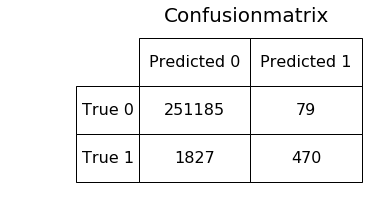

In [56]:
show_confusion_matrix(y_train, logit2.predict(X_train_new4))

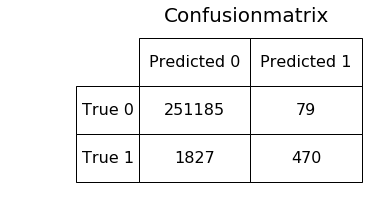

In [57]:
show_confusion_matrix(y_train, logit2.predict(X_train_new4))

In [58]:
#logit_test_pred3 = logit2.predict_proba(X_test_new4)[:, 1]
#write_to_submission_file(logit_test_pred3, 'submissions/35-subm1-no-grid2.csv') # 0.95906


#### Now we tune regularization parameter C.

In [59]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='lbfgs', max_iter=8000)

In [60]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [61]:
#c_values = np.logspace(-2, 2, 10)

params = {
    'C': np.logspace(-2, 2, 10)
#    'penalty': ['l1','l2']
}

logit_grid_searcher = GridSearchCV(estimator=logit2, param_grid=params,
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)
#logit_grid_searcher = GridSearchCV(estimator=logit2, param_grid={'C': c_values},
#                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [62]:
%%time
logit_grid_searcher.fit(X_train_new4, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: 

/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.5min finished


CPU times: user 11min 33s, sys: 30.8 s, total: 12min 3s
Wall time: 2min 31s


/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [63]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_ # 0.9348388521663915

(0.931041522877111, {'C': 1.6681005372000592})

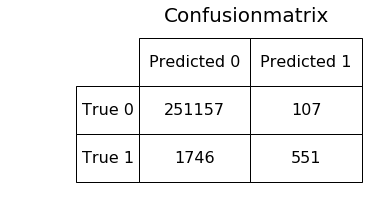

In [65]:
show_confusion_matrix(y_train, logit_grid_searcher.predict(X_train_new4))

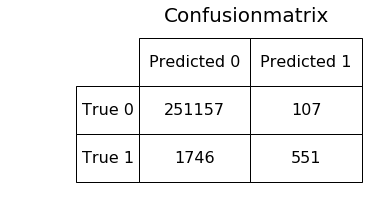

In [66]:
show_confusion_matrix(y_train, logit_grid_searcher.predict(X_train_new4)) 

In [67]:
logit_test_pred3 = logit_grid_searcher.predict_proba(X_test_new4)[:, 1]
write_to_submission_file(logit_test_pred3, 'submissions/35-subm1-with-grid.csv') # 0.95879
